# Emotion Detection

## Preprocessing - Analyze Dataset

In [8]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import  math
import scipy


In [59]:
train_dir = "fer_clean/train"
print("Train directory: " + train_dir)

test_dir = "fer_clean/test"
print("Test directory: " + test_dir)

emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
# emotions = ["angry", "fear", "happy", "neutral", "sad", "surprise"]

Train directory: fer_clean/train
Test directory: fer_clean/test


In [75]:
train_num = [len(os.listdir(os.path.join(train_dir, single_class))) for single_class in emotions]
test_num = [len(os.listdir(os.path.join(test_dir, single_class))) for single_class in emotions]

df = pd.DataFrame({'Train': train_num,'Test': test_num}, index=emotions)
df['Total'] = df.sum(axis=1)
df.loc['Total'] = df.sum()  #Selecting Rows by Label
display(df.transpose())

,angry,disgust,fear,happy,neutral,sad,surprise,Total
Train,3909,3774,4038,7067,4869,4740,3147,31544
Test,920,111,977,1737,1210,1206,810,6971
Total,4829,3885,5015,8804,6079,5946,3957,38515


Text(0, 0.5, 'Emotion')

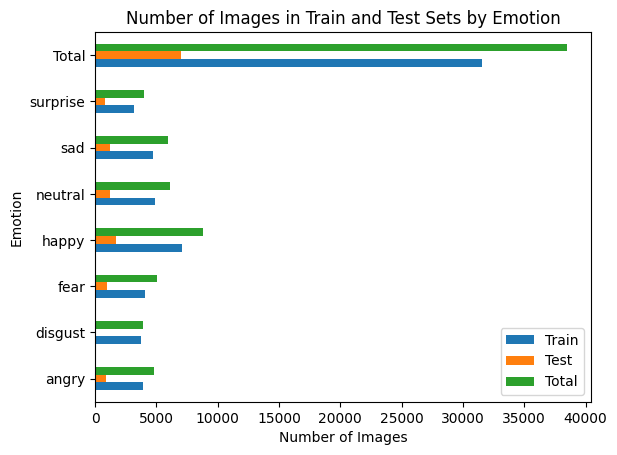

In [76]:
plt.rcdefaults()
df.plot(kind='barh')
plt.title('Number of Images in Train and Test Sets by Emotion')
plt.xlabel('Number of Images')
plt.ylabel('Emotion')

Shuffling the data during the training of a classification model is important for several reasons:

- Avoiding Order Bias:
  - If your dataset has some inherent order or structure (for example, if samples are sorted by class), not shuffling the data may introduce order bias to the model.
  - Shuffling helps ensure that each batch of training samples is representative of the overall distribution of classes in the dataset.

- Reducing Overfitting:
  - In situations where the data has some pattern or order, not shuffling the data could lead the model to learn that pattern instead of generalizing well to new, unseen data.
  - Shuffling helps prevent the model from memorizing the order or patterns in the training set and encourages it to learn more robust features.

- Breaking Dependencies:
  - In some cases, if the data has been collected or organized in a specific order, shuffling helps break any dependencies that might exist between consecutive samples.
  - This is important when using sequential data, time-series data, or any data where the order might have an impact on the learning process.

- Ensuring Randomness:
  - When training models in batches, shuffling ensures that each batch is a random sample from the entire dataset. This randomness can improve the model's ability to generalize to unseen data.

- Avoiding Local Minima:
  - Shuffling helps prevent the model from getting stuck in local minima during optimization by introducing randomness in the order of samples presented to the model.

In method flow_from_directory, shuffle is default to be true

In [77]:
# Rescale all pixels in range [0,1]
train_datgen = ImageDataGenerator(rescale=1./255)
test_datgen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator can be used with the flow_from_directory method to generate batches of images directly from a directory
# returns a directory iterator, which generates batches of data and labels by reading images from a directory

# Preprocess all test images
train_generator = train_datgen.flow_from_directory(
        train_dir,
        target_size=(48, 48), # Do not resize
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical'  # Labels are one-hot encoded
        )

# Preprocess all train images
test_generator = test_datgen.flow_from_directory(
        test_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 31544 images belonging to 7 classes.
Found 6971 images belonging to 7 classes.


In [78]:
train_data = []
train_labels = []

number_of_batches = len(train_generator)

for batch_indx in range(number_of_batches):
  train_batch = next(train_generator)
  train_data.append(train_batch[0])
  train_labels.append(train_batch[1])

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

print("Shape of train_data:", train_data.shape)
print("Shape of train_labels:", train_labels.shape)

Shape of train_data: (31544, 48, 48, 1)
Shape of train_labels: (31544, 7)


In [79]:
test_data = []
test_labels = []

number_of_batches = len(test_generator)

for batch_indx in range(number_of_batches):
  test_batch = next(test_generator)
  test_data.append(test_batch[0])
  test_labels.append(test_batch[1])

test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

print("Shape of test_data:", test_data.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of test_data: (6971, 48, 48, 1)
Shape of test_labels: (6971, 7)


## CNN

In [80]:
import keras.backend as K
import cv2
import tensorflow as tf
import keras_tuner as kt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

### Keras tuner: Tun Hyperparameter

In [81]:
# Model structure
# Using Sequential API: Allows to stack layers one afteranother
# Build Hyper Model to tun Hyper Parameter using Keras tuner

def model_builder(hp):
  X1 = hp.Int("conv1_units", min_value=32, max_value=512, step=8)
  X2 = hp.Int("conv2_units", min_value=32, max_value=512, step=8)
  X3 = hp.Int("conv3_units", min_value=32, max_value=512, step=8)
  X4 = hp.Int("conv4_units", min_value=32, max_value=512, step=8)

  X5 = hp.Float("dropout1", min_value=0.1, max_value=0.3, step=0.05)
  X6 = hp.Float("dropout2", min_value=0.1, max_value=0.3, step=0.05)
  X7 = hp.Float("dropout3", min_value=0.1, max_value=0.5, step=0.1)

  X8 = hp.Choice("dense1_units", values = [32, 64, 128, 256, 512, 1024, 2048])



  model = Sequential([
      Conv2D(X1, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
      Conv2D(X2, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)), # Down sample: --> 1/4 size
      Dropout(X5),

      Conv2D(X3, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(X4, kernel_size=(3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(X6),

      Flatten(),  # Convert 3D output to 1D before go to FC (Dense) layers
      Dense(X8, activation='relu'),
      Dropout(X7),
      Dense(7, activation='softmax')  # FC with 7 units (1 for each class) with softmax activation
  ])

  model.compile(optimizer='adam',  # Adam optimizer
                loss="categorical_crossentropy",  #focal_loss
                metrics=['accuracy'])

  return model

In [82]:
# Init Tuner
tuner = kt.Hyperband(model_builder, objective="val_accuracy", directory="tuner_dir_04", project_name="Emotion-detection-augmentation")

# Early stop
stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

In [83]:
tuner.search(train_data, train_labels, validation_data=(test_data, test_labels), callbacks=[stop_early])

Trial 254 Complete [00h 05m 46s]
val_accuracy: 0.6062257885932922

Best val_accuracy So Far: 0.6327642798423767
Total elapsed time: 06h 47m 30s


In [84]:
# Get the optimal hyperparameters
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]	#Dict of optimal HP

print("[INFO] optimal number of filters in conv_1 layer: {}".format(
	bestHP.get("conv1_units")))
print("[INFO] optimal number of filters in conv_2 layer: {}".format(
	bestHP.get("conv2_units")))
print("[INFO] optimal drop out rate in dropout_1 layer: {}".format(
	bestHP.get("dropout1")))
print("[INFO] optimal number of filters in conv_3 layer: {}".format(
	bestHP.get("conv3_units")))
print("[INFO] optimal number of filters in conv_4 layer: {}".format(
	bestHP.get("conv4_units")))
print("[INFO] optimal drop out rate in dropout_2 layer: {}".format(
	bestHP.get("dropout2")))
print("[INFO] optimal number of units in dense layer: {}".format(
	bestHP.get("dense1_units")))
print("[INFO] optimal drop out rate in dropout_3 layer: {}".format(
	bestHP.get("dropout3")))


[INFO] optimal number of filters in conv_1 layer: 224
[INFO] optimal number of filters in conv_2 layer: 432
[INFO] optimal drop out rate in dropout_1 layer: 0.15000000000000002
[INFO] optimal number of filters in conv_3 layer: 168
[INFO] optimal number of filters in conv_4 layer: 144
[INFO] optimal drop out rate in dropout_2 layer: 0.25
[INFO] optimal number of units in dense layer: 512
[INFO] optimal drop out rate in dropout_3 layer: 0.4


In [85]:
bestHP.values

{'conv1_units': 224,
 'conv2_units': 432,
 'conv3_units': 168,
 'conv4_units': 144,
 'dropout1': 0.15000000000000002,
 'dropout2': 0.25,
 'dropout3': 0.4,
 'dense1_units': 512,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0205'}

### Get best module after tuner

In [86]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
best_model = tuner.hypermodel.build(bestHP)
best_model.summary()
history = best_model.fit(train_data, train_labels, epochs =100, validation_data = (test_data, test_labels))	# Train (as normal)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 224)       2240      
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 432)       871344    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 432)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 432)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 168)       653352    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 168)      0         
 2D)                                                  

2023-12-25 07:13:02.451399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


986/986 [==============================] - 22s 20ms/step - loss: 1.7722 - accuracy: 0.2989 - val_loss: 1.5421 - val_accuracy: 0.4080
Epoch 2/100
986/986 [==============================] - 19s 20ms/step - loss: 1.4100 - accuracy: 0.4632 - val_loss: 1.3299 - val_accuracy: 0.4903
Epoch 3/100
986/986 [==============================] - 19s 20ms/step - loss: 1.2372 - accuracy: 0.5302 - val_loss: 1.2060 - val_accuracy: 0.5417
Epoch 4/100
986/986 [==============================] - 20s 20ms/step - loss: 1.1374 - accuracy: 0.5719 - val_loss: 1.1935 - val_accuracy: 0.5407
Epoch 5/100
986/986 [==============================] - 20s 20ms/step - loss: 1.0706 - accuracy: 0.5944 - val_loss: 1.1504 - val_accuracy: 0.5622
Epoch 6/100
986/986 [==============================] - 20s 20ms/step - loss: 1.0145 - accuracy: 0.6163 - val_loss: 1.1156 - val_accuracy: 0.5752
Epoch 7/100
986/986 [==============================] - 20s 20ms/step - loss: 0.9600 - accuracy: 0.6403 - val_loss: 1.1147 - val_accuracy: 0.58

In [87]:
hypermodel = tuner.hypermodel.build(bestHP)
# Retrain the model
hypermodel_info = hypermodel.fit(train_data, train_labels, epochs=best_epoch, validation_data = (test_data, test_labels))

Epoch 1/84


2023-12-25 07:45:58.429118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


986/986 [==============================] - 22s 20ms/step - loss: 1.7432 - accuracy: 0.3152 - val_loss: 1.5000 - val_accuracy: 0.4239
Epoch 2/84
986/986 [==============================] - 20s 20ms/step - loss: 1.3483 - accuracy: 0.4869 - val_loss: 1.2815 - val_accuracy: 0.5101
Epoch 3/84
986/986 [==============================] - 20s 20ms/step - loss: 1.2043 - accuracy: 0.5467 - val_loss: 1.2586 - val_accuracy: 0.5325
Epoch 4/84
986/986 [==============================] - 20s 20ms/step - loss: 1.1197 - accuracy: 0.5785 - val_loss: 1.1650 - val_accuracy: 0.5600
Epoch 5/84
986/986 [==============================] - 20s 20ms/step - loss: 1.0523 - accuracy: 0.6014 - val_loss: 1.1366 - val_accuracy: 0.5656
Epoch 6/84
986/986 [==============================] - 20s 20ms/step - loss: 0.9925 - accuracy: 0.6244 - val_loss: 1.1053 - val_accuracy: 0.5854
Epoch 7/84
986/986 [==============================] - 20s 20ms/step - loss: 0.9481 - accuracy: 0.6437 - val_loss: 1.1038 - val_accuracy: 0.5861
Epo

Keras then appends an extra dimension for processing multiple batches, i.e., to train multiple images in every step of a single epoch. Since batch size can vary, its size is represented by None. Hence, the input shape becomes (None, 32, 32, 3).

Convolving a (32, 32) image with a (4, 4) filter, with strides and dilation rate of 1, and 'valid' padding, results in an output of size (32 - 4 + 1, 32 - 4 + 1) = (29, 29). Since you have 32 such filters, the output shape becomes (29, 29, 32).

The default MaxPooling kernel has a shape of (2, 2) and strides of (2, 2). Applying that to a (29, 29) image results in an image of shape (((29 - 2)//2) + 1, ((29 - 2)//2) + 1)) = (14, 14).

This pattern can be extended to all Conv2D and MaxPooling layers.

The Flatten layer takes all pixels along all channels and creates a 1D vector (not considering batch size). Therefore, an input of (5, 5, 32) is flattened to (5 * 5 * 32) = 800 values.

Parameter count

The number of parameters for a Conv2D layer is given by:

(kernel_height * kernel_width * input_channels * output_channels) + (output_channels if bias is used).

So, for the first Conv2D layer with 3 input channels, 32 output channels and a kernel size of (4, 4), the number of parameters is (4 * 4 * 3 * 32) + 32 = 1568.

In [45]:
hypermodel.summary()
hypermodel.save('CNN_hypermodel_clean.h5')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 46, 46, 72)        720       
                                                                 
 conv2d_25 (Conv2D)          (None, 44, 44, 432)       280368    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 22, 22, 432)      0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 22, 22, 432)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 20, 432)       1680048   
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 10, 10, 432)      0         
 g2D)                                                 

In [38]:
CNN_base_score = hypermodel.evaluate(test_data, test_labels)
print("Validation Loss: {:.5f}".format(CNN_base_score[0]))
print("Validation Accuracy: {:.2f}%".format(CNN_base_score[1] * 100))

218/218 [==============================] - 1s 5ms/step - loss: 1.6301 - accuracy: 0.6145
Validation Loss: 1.63014
Validation Accuracy: 61.45%


In [39]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "validation_loss")
    plt.xticks(np.arange(0,len(history.history["loss"]) + 1,(len(history.history["loss"]) + 1)//8))
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "validation_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

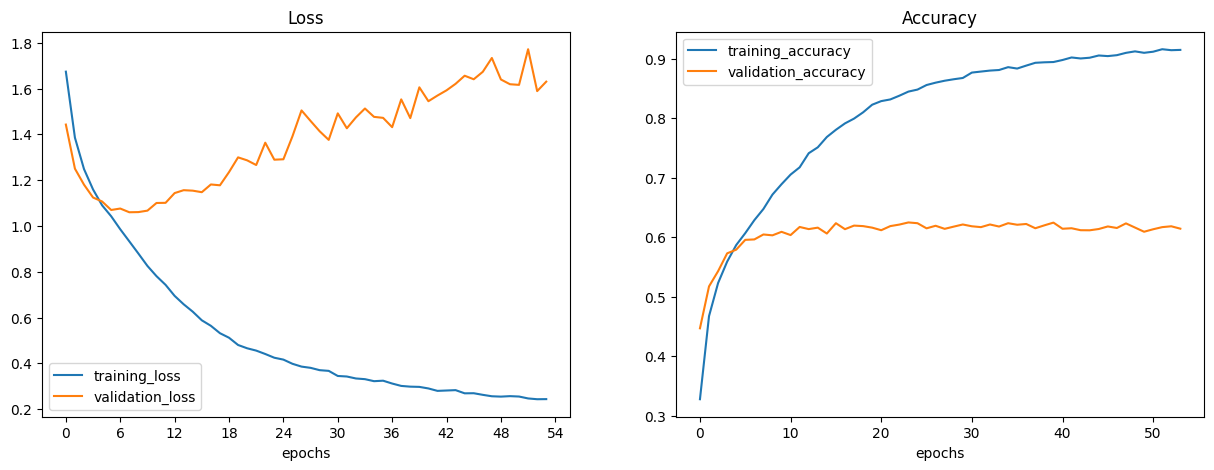

In [40]:
plot_curves(hypermodel_info)

In [41]:
# Predict possibility of each class
CNN_base_predict = hypermodel.predict(test_generator)

# Choosing highest probalbilty class in every prediction 
CNN_base_predict = np.argmax(CNN_base_predict, axis=1)

109/109 [==============================] - 3s 28ms/step


<Figure size 640x480 with 0 Axes>

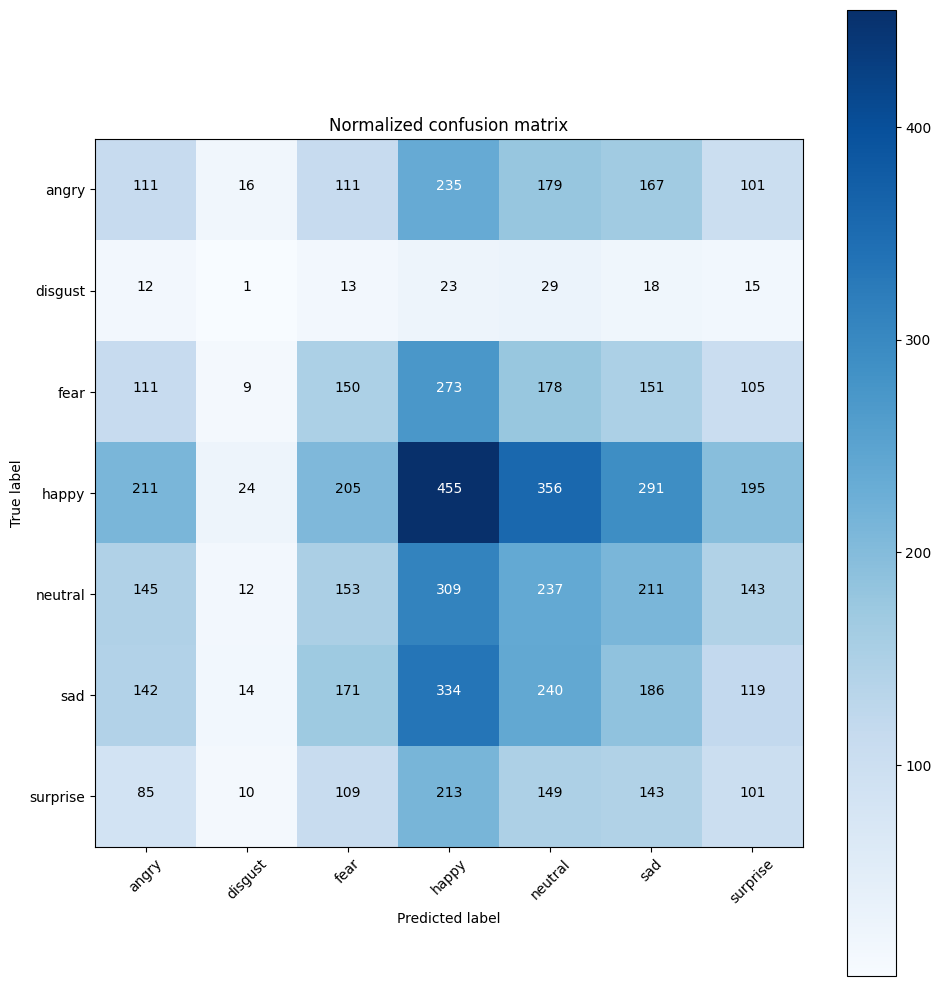

In [42]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(test_generator.labels, CNN_base_predict)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=test_generator.class_indices.keys(), title='Normalized confusion matrix')
plt.show()

### Dynamic Learning Rate

In [88]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
best_dynamic_lr_model = tuner.hypermodel.build(bestHP)

checkpoint = ModelCheckpoint("./CNN_dynamiclr6class.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
callbacks_list = [checkpoint,reduce_learningrate]

history_dynamic = best_dynamic_lr_model.fit(train_data, train_labels, epochs =45, validation_data = (test_data, test_labels), callbacks=callbacks_list)	# Train (as normal)
val_acc_per_epoch_dynamic = history_dynamic.history['val_accuracy']
best_epoch_dynamic = val_acc_per_epoch_dynamic.index(max(val_acc_per_epoch_dynamic)) + 1
print('Best epoch: %d' % (best_epoch_dynamic,))

Epoch 1/45


2023-12-25 08:17:23.754729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


986/986 [==============================] - 22s 20ms/step - loss: 1.6371 - accuracy: 0.3608 - val_loss: 1.3409 - val_accuracy: 0.4912 - lr: 0.0010
Epoch 2/45
986/986 [==============================] - 19s 20ms/step - loss: 1.2595 - accuracy: 0.5237 - val_loss: 1.2014 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 3/45
986/986 [==============================] - 19s 19ms/step - loss: 1.1344 - accuracy: 0.5750 - val_loss: 1.1737 - val_accuracy: 0.5519 - lr: 0.0010
Epoch 4/45
986/986 [==============================] - 19s 19ms/step - loss: 1.0502 - accuracy: 0.6042 - val_loss: 1.1493 - val_accuracy: 0.5586 - lr: 0.0010
Epoch 5/45
986/986 [==============================] - 19s 19ms/step - loss: 0.9793 - accuracy: 0.6313 - val_loss: 1.1093 - val_accuracy: 0.5807 - lr: 0.0010
Epoch 6/45
986/986 [==============================] - 19s 19ms/step - loss: 0.9154 - accuracy: 0.6538 - val_loss: 1.0876 - val_accuracy: 0.5912 - lr: 0.0010
Epoch 7/45
986/986 [==============================] - 19s 19ms/step -

In [89]:
hypermodel_dynamic = tuner.hypermodel.build(bestHP)

# Retrain the model
hypermodel_dynamic_info = hypermodel_dynamic.fit(train_data, train_labels, epochs =best_epoch_dynamic, validation_data = (test_data, test_labels), callbacks=callbacks_list)

Epoch 1/19


2023-12-25 08:33:47.282471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


986/986 [==============================] - 22s 20ms/step - loss: 1.6610 - accuracy: 0.3504 - val_loss: 1.4143 - val_accuracy: 0.4542 - lr: 0.0010
Epoch 2/19
986/986 [==============================] - 20s 20ms/step - loss: 1.3014 - accuracy: 0.5064 - val_loss: 1.2773 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 3/19
986/986 [==============================] - 20s 20ms/step - loss: 1.1727 - accuracy: 0.5621 - val_loss: 1.1771 - val_accuracy: 0.5569 - lr: 0.0010
Epoch 4/19
986/986 [==============================] - 20s 20ms/step - loss: 1.0772 - accuracy: 0.5962 - val_loss: 1.1382 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 5/19
986/986 [==============================] - 20s 20ms/step - loss: 1.0125 - accuracy: 0.6173 - val_loss: 1.1035 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 6/19
986/986 [==============================] - 20s 20ms/step - loss: 0.9566 - accuracy: 0.6428 - val_loss: 1.1054 - val_accuracy: 0.5857 - lr: 0.0010
Epoch 7/19
986/986 [==============================] - 20s 20ms/step -

In [90]:
hypermodel_dynamic.summary()
hypermodel_dynamic.save("CNN_hypermodel_dynamic_clean.h5")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 46, 46, 224)       2240      
                                                                 
 conv2d_17 (Conv2D)          (None, 44, 44, 432)       871344    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 22, 22, 432)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 22, 22, 432)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 168)       653352    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 168)      0         
 g2D)                                                 

In [91]:
CNN_dynamic_score = hypermodel_dynamic.evaluate(test_data, test_labels)
print("Validation Loss: {:.5f}".format(CNN_dynamic_score[0]))
print("Validation Accuracy: {:.2f}%".format(CNN_dynamic_score[1] * 100))

218/218 [==============================] - 1s 6ms/step - loss: 1.1607 - accuracy: 0.6325
Validation Loss: 1.16067
Validation Accuracy: 63.25%


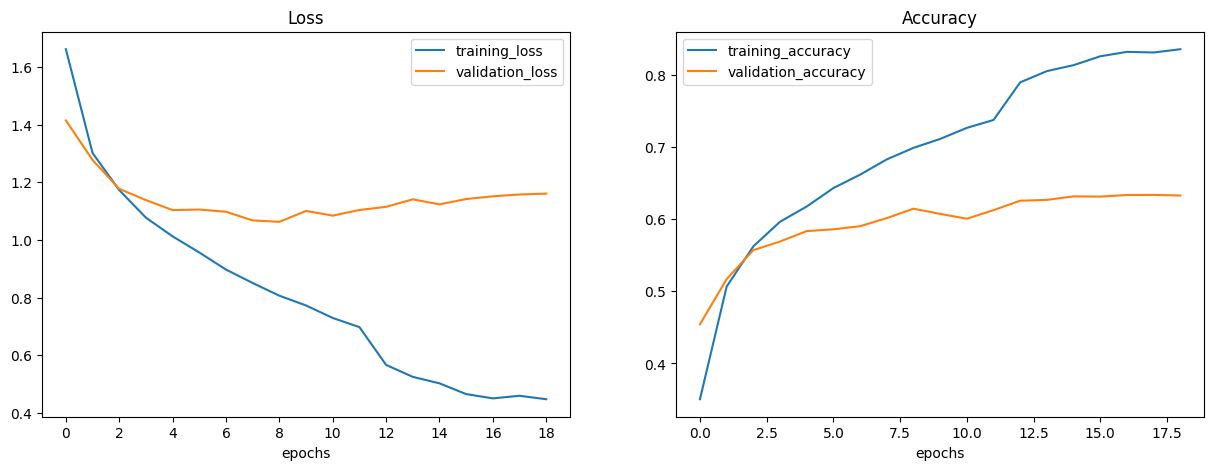

In [92]:
plot_curves(hypermodel_dynamic_info)

In [93]:
# Predict possibility of each class
CNN_dynamic_predict = hypermodel_dynamic.predict(test_generator)

# Choosing highest probalbilty class in every prediction 
CNN_dynamic_predict = np.argmax(CNN_dynamic_predict, axis=1)

109/109 [==============================] - 6s 44ms/step


<Figure size 640x480 with 0 Axes>

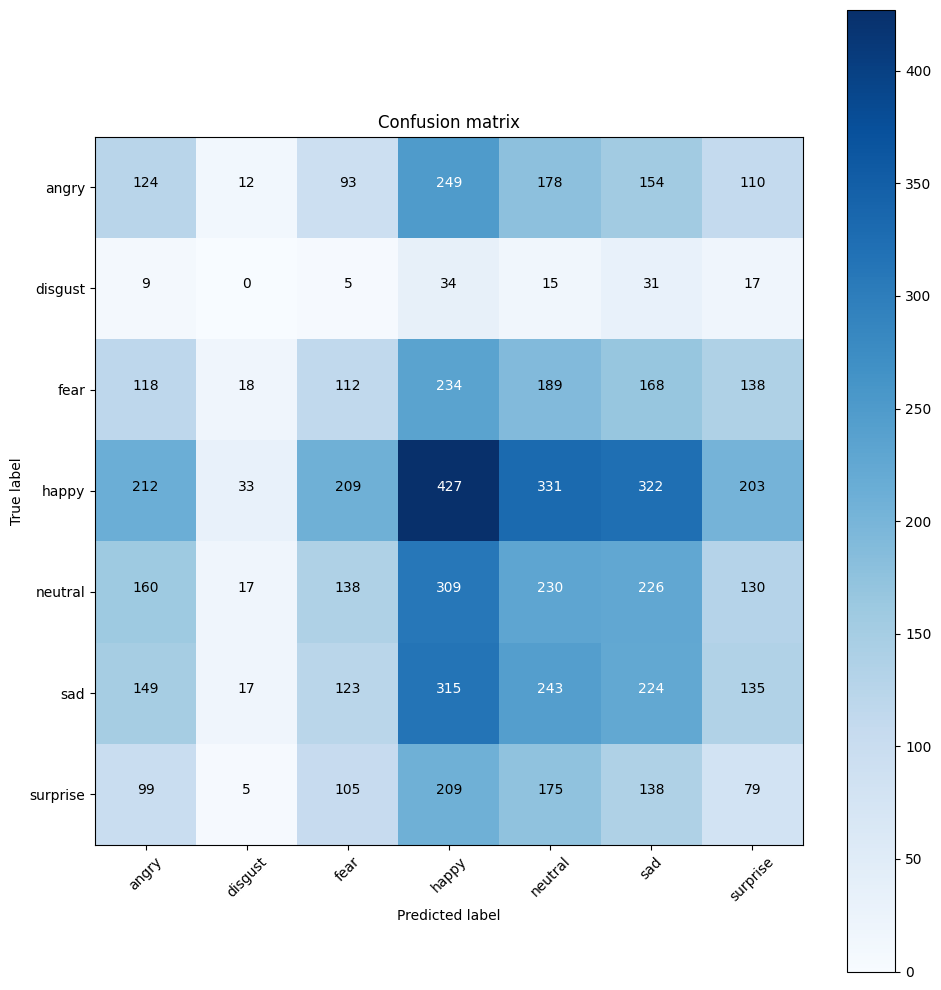

In [94]:
cnf_matrix_dynamic = confusion_matrix(test_generator.labels, CNN_dynamic_predict)

plt.figure()
plot_confusion_matrix(cnf_matrix_dynamic, classes=test_generator.class_indices.keys(), title='Confusion matrix')
plt.show()